## Setup

In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn statsmodels scipy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

X = df[["petal_length", "petal_width"]].values
y = df["species"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(df.groupby("species")[["petal_length","petal_width"]].mean().round(2))

         petal_length  petal_width
species                           
0                1.46         0.25
1                4.26         1.33
2                5.55         2.03


## Step 1 — Logistic Regression

### 1a) Binary Logistic Regression (Setosa vs Rest)

Binary LR Accuracy: 1.0000


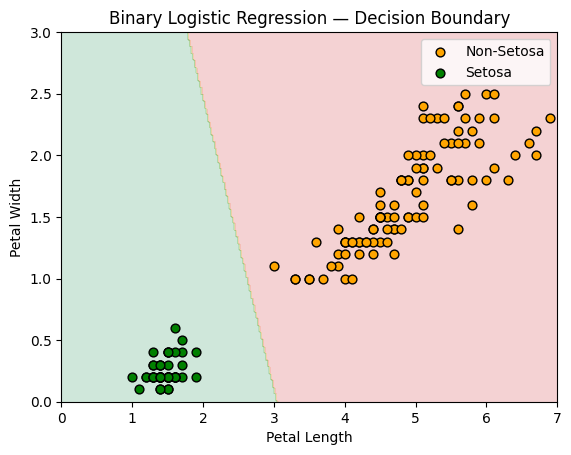

In [2]:
y_bin = (y == 0).astype(int)
y_train_b, y_test_b = (y_train == 0).astype(int), (y_test == 0).astype(int)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train_b)
print(f"Binary LR Accuracy: {accuracy_score(y_test_b, lr.predict(X_test)):.4f}")

# Decision boundary
xx, yy = np.meshgrid(np.linspace(0, 7, 300), np.linspace(0, 3, 300))
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap="RdYlGn")
for cls, label, color in zip([0,1], ["Non-Setosa","Setosa"], ["orange","green"]):
    m = y_bin == cls
    plt.scatter(X[m,0], X[m,1], label=label, color=color, edgecolor="k", s=40)
plt.xlabel("Petal Length"); plt.ylabel("Petal Width")
plt.title("Binary Logistic Regression — Decision Boundary"); plt.legend(); plt.show()

### 1b) Standard Error, z-Statistic, p-Value

In [3]:
X_sm = sm.add_constant(df[["petal_length","petal_width"]])
model = sm.Logit((y == 0).astype(int), X_sm).fit(disp=False)

coef_df = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error":  model.bse,
    "z-Statistic": model.tvalues,
    "p-Value":     model.pvalues,
}).round(4)
coef_df["Significance"] = coef_df["p-Value"].apply(
    lambda p: "***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else "ns")

print(coef_df)

              Coefficient  Std. Error  z-Statistic  p-Value Significance
const             61.1055  21221.5704       0.0029   0.9977           ns
petal_length     -17.8041  18322.8016      -0.0010   0.9992           ns
petal_width      -23.2555  36408.3997      -0.0006   0.9995           ns


### 1c) Confounding Variables

Correlation with Setosa target:
               target
sepal_length  -0.717
sepal_width    0.603
petal_length  -0.923
petal_width   -0.887
species       -0.866
target         1.000

Petal-only coefficients:
 const           61.1055
petal_length   -17.8041
petal_width    -23.2555
dtype: float64

Full-model coefficients:
 const          -11.8568
sepal_length     9.6294
sepal_width      8.4423
petal_length   -20.5324
petal_width    -14.9497
dtype: float64

→ Adding sepal features shifts petal coefficients → partial confounding.
→ Sepal length correlates with both species and petal features (VIF risk).


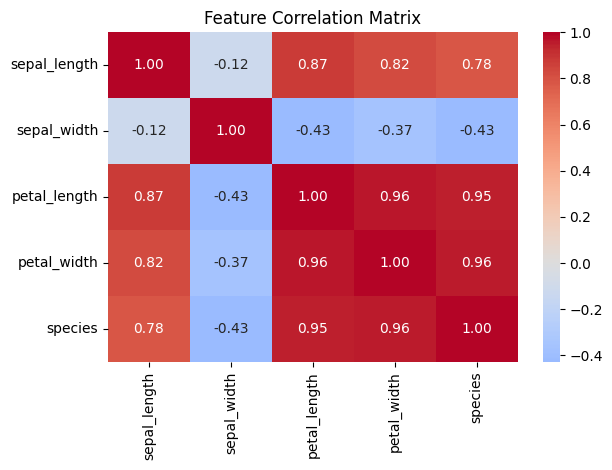

In [4]:
# Correlation of all features with binary target
corr = df.assign(target=(df.species==0).astype(int)).corr()[["target"]].round(3)
print("Correlation with Setosa target:\n", corr)

# Fit petal-only vs all-features model and compare coefficients
m_petal = sm.Logit((y==0).astype(int), sm.add_constant(df[["petal_length","petal_width"]])).fit(disp=False)
m_full  = sm.Logit((y==0).astype(int), sm.add_constant(df[["sepal_length","sepal_width","petal_length","petal_width"]])).fit(disp=False)

print("\nPetal-only coefficients:\n", m_petal.params.round(4))
print("\nFull-model coefficients:\n", m_full.params.round(4))
print("\n→ Adding sepal features shifts petal coefficients → partial confounding.")
print("→ Sepal length correlates with both species and petal features (VIF risk).")

# Correlation heatmap
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix"); plt.tight_layout(); plt.show()

### 1d) Multi-Class Logistic Regression (3 classes)

Multi-class LR Accuracy: 0.9333

Coefficients (one row per class):
             PetalLength  PetalWidth
setosa          -2.4869     -1.0758
versicolor       0.1279     -0.8098
virginica        2.3590      1.8856


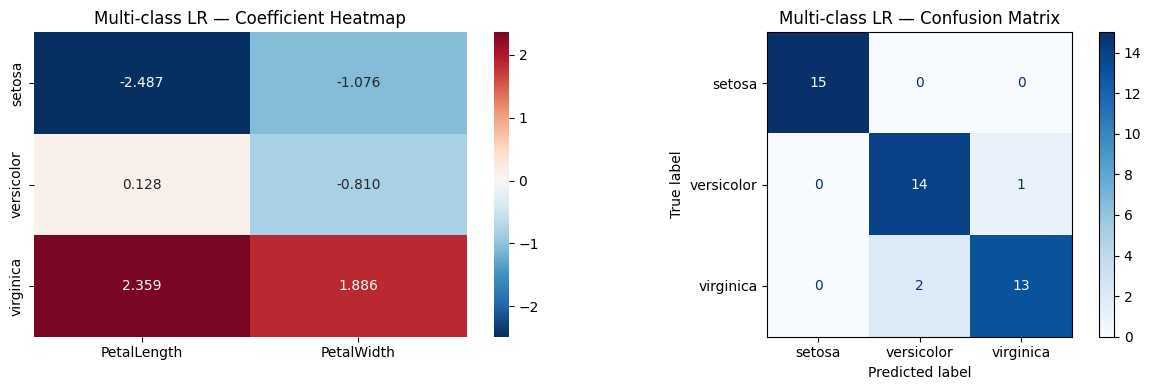

In [6]:
lr_mc = LogisticRegression(
	# multi_class="multinomial", 
	max_iter=500, random_state=42)
lr_mc.fit(X_train, y_train)
y_pred_mc = lr_mc.predict(X_test)
print(f"Multi-class LR Accuracy: {accuracy_score(y_test, y_pred_mc):.4f}")

coef_df = pd.DataFrame(lr_mc.coef_, index=iris.target_names, columns=["PetalLength","PetalWidth"])
print("\nCoefficients (one row per class):\n", coef_df.round(4))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(coef_df, annot=True, fmt=".3f", cmap="RdBu_r", center=0, ax=axes[0])
axes[0].set_title("Multi-class LR — Coefficient Heatmap")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mc, display_labels=iris.target_names, ax=axes[1], cmap="Blues")
axes[1].set_title("Multi-class LR — Confusion Matrix")
plt.tight_layout(); plt.show()

## Step 2 — Discriminant Analysis

### 2a) Linear Discriminant Analysis

LDA Accuracy: 0.9111
Explained variance ratio: [0.9945 0.0055]


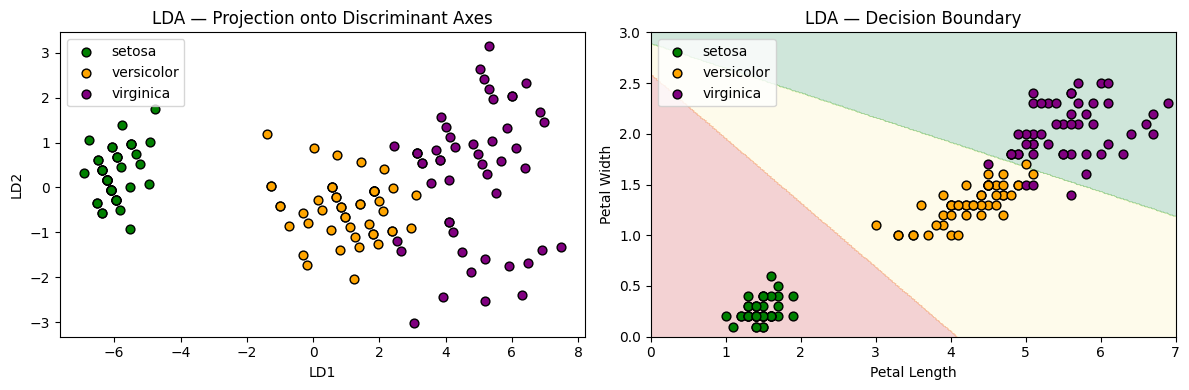

In [7]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print(f"LDA Accuracy: {accuracy_score(y_test, y_pred_lda):.4f}")
print(f"Explained variance ratio: {lda.explained_variance_ratio_.round(4)}")

# Plot LDA projection and decision boundary
fig, axes = plt.subplots(1, 2, figsize=(12,4))
X_proj = lda.transform(X)
colors = ["green","orange","purple"]
for cls, color, name in zip([0,1,2], colors, iris.target_names):
    m = y == cls
    axes[0].scatter(X_proj[m,0], X_proj[m,1], color=color, label=name, edgecolor="k", s=40)
axes[0].set_xlabel("LD1"); axes[0].set_ylabel("LD2")
axes[0].set_title("LDA — Projection onto Discriminant Axes"); axes[0].legend()

ZZ = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, ZZ, alpha=0.2, cmap="RdYlGn")
for cls, color, name in zip([0,1,2], colors, iris.target_names):
    m = y == cls
    axes[1].scatter(X[m,0], X[m,1], color=color, label=name, edgecolor="k", s=40)
axes[1].set_xlabel("Petal Length"); axes[1].set_ylabel("Petal Width")
axes[1].set_title("LDA — Decision Boundary"); axes[1].legend()
plt.tight_layout(); plt.show()

### 2b) Effective Threshold

Best threshold (max F1): 0.680  |  F1 = 1.0000


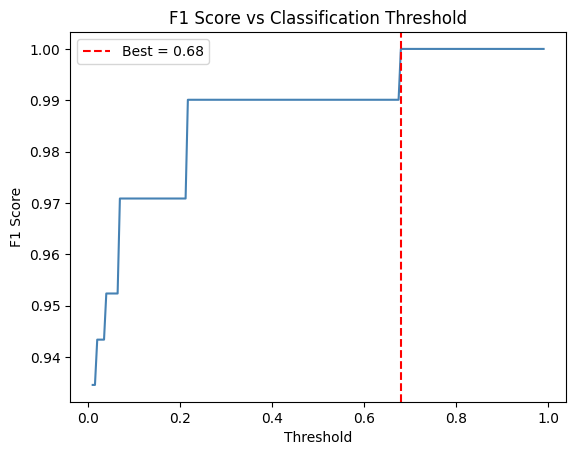

In [8]:
lda_bin = LinearDiscriminantAnalysis()
lda_bin.fit(X_train, (y_train==0).astype(int))
y_prob = lda_bin.predict_proba(X)[:,1]
y_true_bin = (y == 0).astype(int)

thresholds = np.linspace(0.01, 0.99, 200)
f1_scores  = []
for thr in thresholds:
    pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, pred, labels=[0,1]).ravel()
    prec = tp/(tp+fp) if (tp+fp) > 0 else 0
    rec  = tp/(tp+fn) if (tp+fn) > 0 else 0
    f1_scores.append(2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0)

best_thr = thresholds[np.argmax(f1_scores)]
print(f"Best threshold (max F1): {best_thr:.3f}  |  F1 = {max(f1_scores):.4f}")

plt.plot(thresholds, f1_scores, color="steelblue")
plt.axvline(best_thr, color="red", linestyle="--", label=f"Best = {best_thr:.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 Score")
plt.title("F1 Score vs Classification Threshold"); plt.legend(); plt.show()

### 2c) ROC Curve

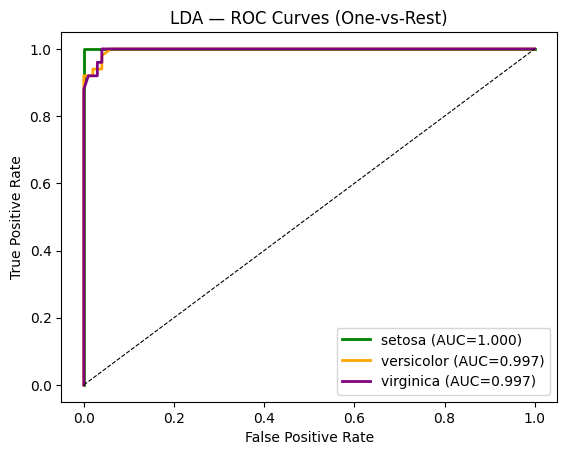

In [9]:
y_bin_mc  = label_binarize(y, classes=[0,1,2])
y_prob_lda = lda.predict_proba(X)
colors = ["green","orange","purple"]

for i, (name, color) in enumerate(zip(iris.target_names, colors)):
    fpr, tpr, _ = roc_curve(y_bin_mc[:,i], y_prob_lda[:,i])
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],"k--", lw=0.8)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("LDA — ROC Curves (One-vs-Rest)"); plt.legend(); plt.show()

### 2d) Quadratic Discriminant Analysis

QDA Accuracy: 0.9333

setosa covariance matrix:
         PL      PW
PL  0.0236  0.0038
PW  0.0038  0.0095

versicolor covariance matrix:
         PL      PW
PL  0.2177  0.0658
PW  0.0658  0.0367

virginica covariance matrix:
         PL      PW
PL  0.3322  0.0493
PW  0.0493  0.0657


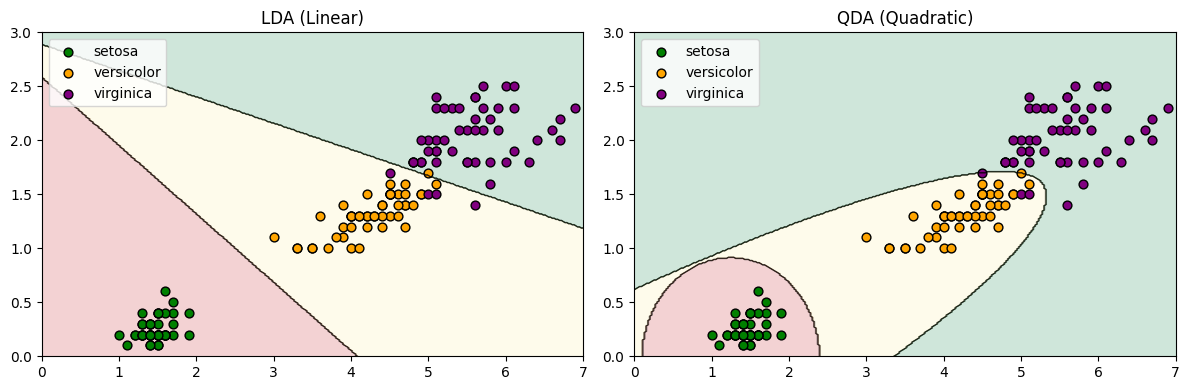

In [10]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print(f"QDA Accuracy: {accuracy_score(y_test, y_pred_qda):.4f}")

for i, name in enumerate(iris.target_names):
    print(f"\n{name} covariance matrix:\n", pd.DataFrame(
        qda.covariance_[i], index=["PL","PW"], columns=["PL","PW"]).round(4))

# LDA vs QDA decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(12,4))
for ax, model, title in zip(axes, [lda, qda], ["LDA (Linear)", "QDA (Quadratic)"]):
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, ZZ, alpha=0.2, cmap="RdYlGn")
    ax.contour(xx, yy, ZZ, colors="k", linewidths=0.6, alpha=0.5)
    for cls, color, name in zip([0,1,2], ["green","orange","purple"], iris.target_names):
        m = y == cls
        ax.scatter(X[m,0], X[m,1], color=color, label=name, edgecolor="k", s=40)
    ax.set_title(title); ax.legend()
plt.tight_layout(); plt.show()

## Step 3 — Naive Bayes

Naive Bayes Accuracy: 0.9333

Gaussian NB Parameters:
      Class  Prior  PL mean  PL var  PW mean  PW var
    setosa 0.3333   1.4857  0.0229   0.2400  0.0093
versicolor 0.3333   4.2371  0.2115   1.3086  0.0356
 virginica 0.3333   5.6314  0.3227   2.0686  0.0639


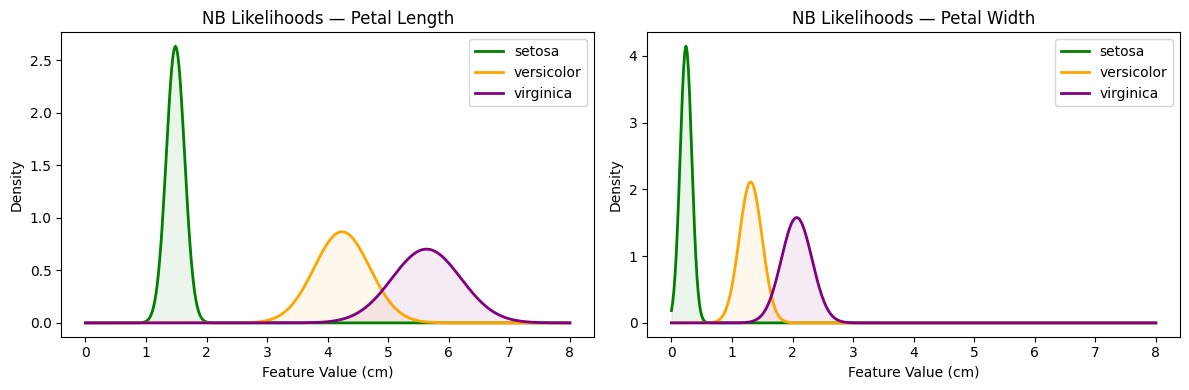

In [11]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")

params_df = pd.DataFrame({
    "Class":    iris.target_names,
    "Prior":    nb.class_prior_.round(4),
    "PL mean":  nb.theta_[:,0].round(4),
    "PL var":   nb.var_[:,0].round(4),
    "PW mean":  nb.theta_[:,1].round(4),
    "PW var":   nb.var_[:,1].round(4),
})
print("\nGaussian NB Parameters:\n", params_df.to_string(index=False))

# Gaussian likelihood curves per class
x_range = np.linspace(0, 8, 400)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
for i, (name, color) in enumerate(zip(iris.target_names, ["green","orange","purple"])):
    for ax, feat in zip(axes, [0, 1]):
        mu, sigma = nb.theta_[i,feat], np.sqrt(nb.var_[i,feat])
        ax.plot(x_range, stats.norm.pdf(x_range, mu, sigma), color=color, lw=2, label=name)
        ax.fill_between(x_range, stats.norm.pdf(x_range, mu, sigma), alpha=0.08, color=color)
axes[0].set_title("NB Likelihoods — Petal Length"); axes[0].legend()
axes[1].set_title("NB Likelihoods — Petal Width");  axes[1].legend()
for ax in axes: ax.set_xlabel("Feature Value (cm)"); ax.set_ylabel("Density")
plt.tight_layout(); plt.show()

## Step 4 — Compare LR, LDA, QDA, NB

                  CV Mean  CV Std  Test Acc
Model                                      
LR (Multinomial)   0.9600  0.0442    0.9333
LDA                0.9600  0.0442    0.9111
QDA                0.9733  0.0327    0.9333
Naive Bayes        0.9600  0.0442    0.9333


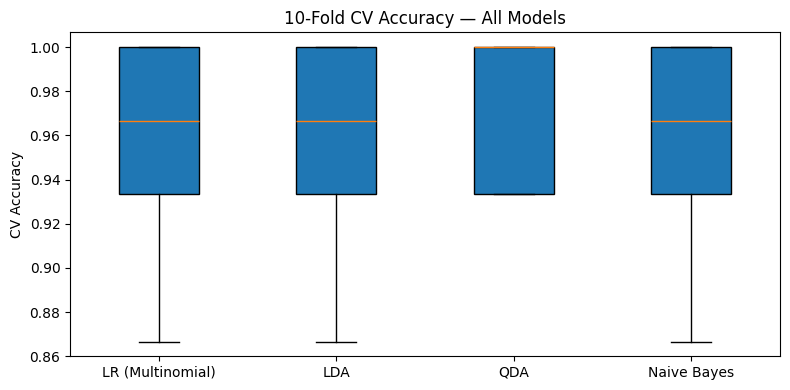

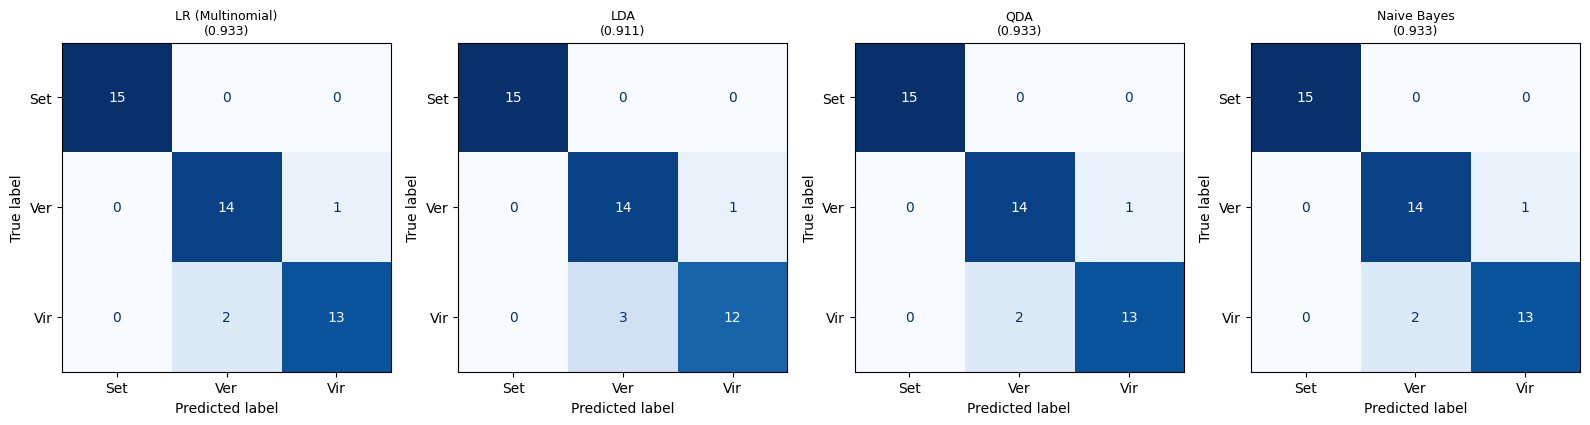


Model Properties:
                     Boundary    Cov. Assumption         Best When
LR (Multinomial)      Linear               None           Large n
LDA                   Linear           Shared Σ  Small n, equal Σ
QDA                Quadratic          Class Σ_k         Unequal Σ
Naive Bayes       Non-linear  Diagonal (indep.)     High-dim data


In [12]:
from sklearn.model_selection import cross_val_score

models = {
    "LR (Multinomial)": LogisticRegression(
        # multi_class="multinomial", 
        max_iter=500, random_state=42),
    "LDA":              LinearDiscriminantAnalysis(),
    "QDA":              QuadraticDiscriminantAnalysis(),
    "Naive Bayes":      GaussianNB(),
}

results = []
for name, model in models.items():
    cv  = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    results.append({"Model": name, "CV Mean": cv.mean(), "CV Std": cv.std(), "Test Acc": test_acc})

results_df = pd.DataFrame(results).set_index("Model").round(4)
print(results_df)

# CV accuracy boxplot
cv_data = {name: cross_val_score(m, X, y, cv=10) for name, m in models.items()}
plt.figure(figsize=(8,4))
plt.boxplot(cv_data.values(), labels=cv_data.keys(), patch_artist=True)
plt.ylabel("CV Accuracy"); plt.title("10-Fold CV Accuracy — All Models"); plt.tight_layout(); plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16,4))
for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    ConfusionMatrixDisplay.from_predictions(
        y_test, model.predict(X_test),
        display_labels=["Set","Ver","Vir"], ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name}\n({accuracy_score(y_test, model.predict(X_test)):.3f})", fontsize=9)
plt.tight_layout(); plt.show()

# Summary properties table
props = pd.DataFrame({
    "Boundary":   ["Linear","Linear","Quadratic","Non-linear"],
    "Cov. Assumption": ["None","Shared Σ","Class Σ_k","Diagonal (indep.)"],
    "Best When":  ["Large n","Small n, equal Σ","Unequal Σ","High-dim data"],
}, index=list(models.keys()))
print("\nModel Properties:\n", props)

## Step 5 — Compare Linear and Poisson Regression

In [13]:
# Simulate count data: doctor visits ~ Poisson(exp(1.2 + 0.6*income - 0.4*age))
np.random.seed(42)
n = 200
income = (np.random.normal(50, 15, n) - 50) / 15
age    = (np.random.uniform(20, 80, n) - 45) / 15
mu_true = np.exp(1.2 + 0.6*income - 0.4*age)
y_count = np.random.poisson(mu_true)

pois_df = pd.DataFrame({"income": income, "age": age, "visits": y_count})
print(f"y — mean: {y_count.mean():.2f}, var: {y_count.var():.2f}  (≈ equal → Poisson appropriate)")

X_reg = sm.add_constant(pois_df[["income","age"]])

# OLS
ols = sm.OLS(y_count, X_reg).fit()
print("\n--- OLS Summary ---")
print(ols.summary().tables[1])

# Poisson GLM
glm = sm.GLM(y_count, X_reg, family=sm.families.Poisson()).fit()
print("\n--- Poisson GLM Summary ---")
print(glm.summary().tables[1])

# IRR interpretation
print("\nPoisson Incidence Rate Ratios (exp(β)):")
print(np.exp(glm.params).round(4))

y — mean: 3.75, var: 15.12  (≈ equal → Poisson appropriate)

--- OLS Summary ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3252      0.197     21.924      0.000       3.936       4.714
income         2.2839      0.205     11.133      0.000       1.879       2.689
age           -1.5130      0.161     -9.398      0.000      -1.830      -1.195

--- Poisson GLM Summary ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1956      0.042     28.518      0.000       1.113       1.278
income         0.5924      0.038     15.663      0.000       0.518       0.667
age           -0.4148      0.032    -12.881      0.000      -0.478      -0.352

Poisson Incidence Rate Ratios (exp(β)):
const     3.3056
income    1.8084
age       0.6605
dtype: f

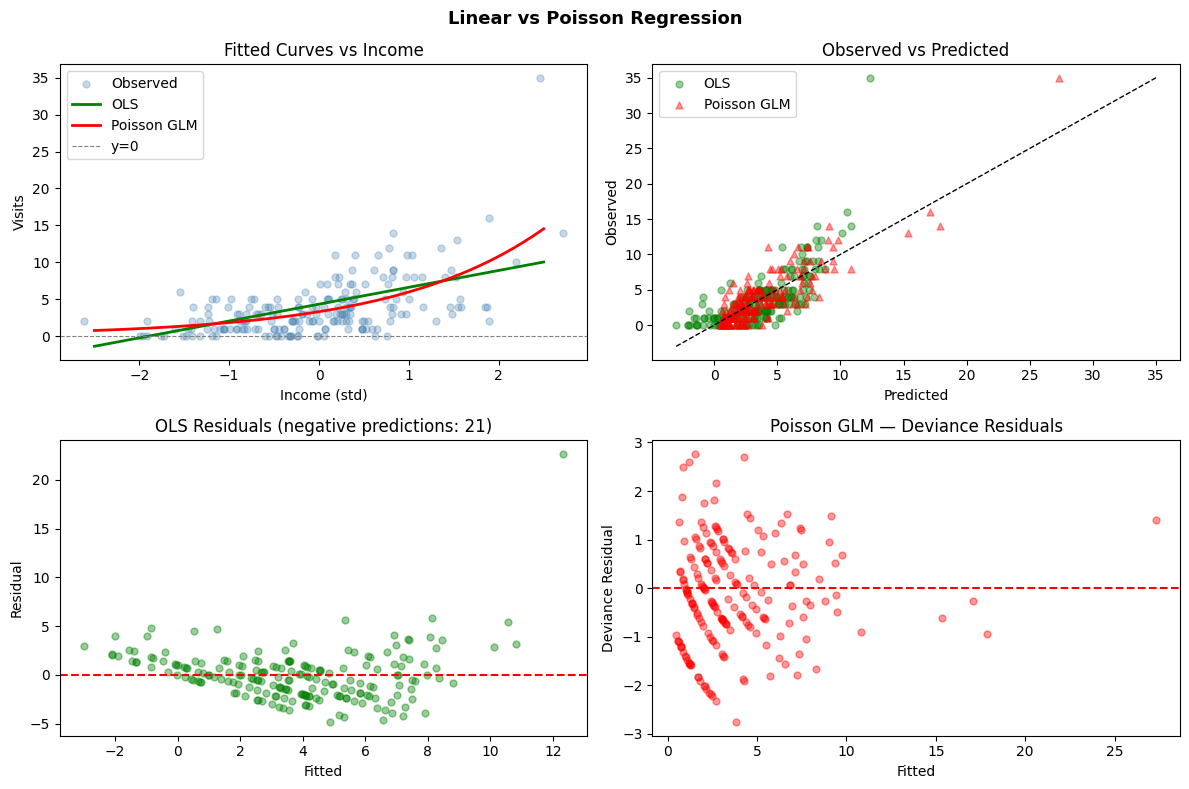


Model Comparison:
                      OLS (Linear) Poisson GLM
MSE                      7.141301     3.73938
MAE                      1.828972    1.486803
Negative predictions           21           0
AIC                    966.754411  769.753137
Link function            Identity         Log
Error distribution       Gaussian     Poisson
Suitable for counts          No ❌       Yes ✅


In [14]:

# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Fitted curves vs income (age fixed at mean)
x_range = np.linspace(-2.5, 2.5, 200)
X_plot  = sm.add_constant(pd.DataFrame({"income": x_range, "age": 0}))
ols_hat = ols.predict(X_plot)
glm_hat = glm.predict(X_plot)

axes[0,0].scatter(income, y_count, alpha=0.3, s=25, color="steelblue", label="Observed")
axes[0,0].plot(x_range, ols_hat, "g-", lw=2, label="OLS")
axes[0,0].plot(x_range, glm_hat, "r-", lw=2, label="Poisson GLM")
axes[0,0].axhline(0, color="gray", linestyle="--", lw=0.8, label="y=0")
axes[0,0].set_xlabel("Income (std)"); axes[0,0].set_ylabel("Visits")
axes[0,0].set_title("Fitted Curves vs Income"); axes[0,0].legend()

# 2. Observed vs predicted
axes[0,1].scatter(ols.fittedvalues, y_count, alpha=0.4, s=25, color="green", label="OLS")
axes[0,1].scatter(glm.fittedvalues, y_count, alpha=0.4, s=25, color="red", marker="^", label="Poisson GLM")
lim = [min(y_count.min(), ols.fittedvalues.min()), max(y_count.max(), ols.fittedvalues.max())]
axes[0,1].plot(lim, lim, "k--", lw=1)
axes[0,1].set_xlabel("Predicted"); axes[0,1].set_ylabel("Observed")
axes[0,1].set_title("Observed vs Predicted"); axes[0,1].legend()

# 3. OLS residuals
axes[1,0].scatter(ols.fittedvalues, ols.resid, alpha=0.4, s=25, color="green")
axes[1,0].axhline(0, color="red", linestyle="--")
neg_count = (ols.fittedvalues < 0).sum()
axes[1,0].set_title(f"OLS Residuals (negative predictions: {neg_count})")
axes[1,0].set_xlabel("Fitted"); axes[1,0].set_ylabel("Residual")

# 4. Poisson deviance residuals
axes[1,1].scatter(glm.fittedvalues, glm.resid_deviance, alpha=0.4, s=25, color="red")
axes[1,1].axhline(0, color="red", linestyle="--")
axes[1,1].set_title("Poisson GLM — Deviance Residuals")
axes[1,1].set_xlabel("Fitted"); axes[1,1].set_ylabel("Deviance Residual")

plt.suptitle("Linear vs Poisson Regression", fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()

# Summary comparison table
from sklearn.metrics import mean_squared_error, mean_absolute_error
summary = pd.DataFrame({
    "MSE":                  [mean_squared_error(y_count, ols.fittedvalues),
                             mean_squared_error(y_count, glm.fittedvalues)],
    "MAE":                  [mean_absolute_error(y_count, ols.fittedvalues),
                             mean_absolute_error(y_count, glm.fittedvalues)],
    "Negative predictions": [(ols.fittedvalues < 0).sum(), (glm.fittedvalues < 0).sum()],
    "AIC":                  [ols.aic, glm.aic],
    "Link function":        ["Identity", "Log"],
    "Error distribution":   ["Gaussian", "Poisson"],
    "Suitable for counts":  ["No ❌", "Yes ✅"],
}, index=["OLS (Linear)", "Poisson GLM"]).T
print("\nModel Comparison:\n", summary)